In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from cellpack_analysis.utilities.PILR_tools import average_over_dimension

Read in average PILR

In [ ]:
base_folder = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/sample_8d"

In [ ]:
with open(f"{base_folder}/avg_PILR.json", "r") as f:
    avg_pilr = json.load(f)

In [ ]:
for key in avg_pilr.keys():
    avg_pilr[key] = np.array(avg_pilr[key])

In [ ]:
avg_pilr.keys()

Channel name dictionary

In [ ]:
ch_names_dict = {
    "SLC25A17": "Peroxisome",
    "membrane": "Membrane",
    "random": "Random",
    "nucleus_linear": "Weak",
    "nucleus_square": "Moderate",
    "nucleus_cube": "Strong",
    "nucleus_twelve": "Stronger",
}

In [ ]:
ch_colors_dict = {
    "SLC25A17": "C0",
    "membrane": "C1",
    "random": "C2",
    "nucleus_linear": "C3",
    "nucleus_square": "C4",
    "nucleus_cube": "C5",
    "nucleus_twelve": "C6",
}

### Plot radial profile

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2), dpi=300)
for ch in ["SLC25A17", "nucleus_linear", "nucleus_square", "nucleus_cube", "nucleus_twelve"]:
# for ch in ["SLC25A17", "membrane", "random", "nucleus_square"]:
    pilr = avg_pilr[ch]
    pilrsum = np.sum(pilr, axis=1)
    pilrsum = pilrsum / np.sum(pilrsum)
    linewidth = 4 if ch == "SLC25A17" else 2
    alpha = 1 if ch == "SLC25A17" else 0.6
    ax.plot(np.linspace(0,1, len(pilrsum)), pilrsum, label=ch_names_dict[ch], linewidth=linewidth, alpha=alpha, color=ch_colors_dict[ch])

ax.plot([0.5, 0.5], [0, 0.08], "--", color="black", label="Nuclear boundary")
ax.set_xlabel("Normalized distance from the nuclear centroid")
ax.set_ylabel("Normalized radial PILR")
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xlim([0,1])   
ax.set_ylim([0,0.08]) 
# put legend on the right outside the axis
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.legend()
fig.savefig(f"{base_folder}/avg_PILR_squeezed.png", dpi=300, bbox_inches="tight")


Get correlations between average PILRs

In [ ]:
df = pd.DataFrame(
    index=ch_names_dict.values(), columns=ch_names_dict.values(), dtype=float
)
std_df = pd.DataFrame(
    index=ch_names_dict.values(), columns=ch_names_dict.values(), dtype=float
)

### Calculate correlations between channels

In [ ]:
from cellpack_analysis.utilities.PILR_tools import get_processed_PILR_from_dict

In [ ]:
mask_nucleus = True
average_over_phi = True

for ch_ind, ch_name in ch_names_dict.items():
    if ch_ind not in avg_pilr:
        continue
    pilr1, std_pilr1 = get_processed_PILR_from_dict(avg_pilr, ch_ind, average_over_phi=average_over_phi, mask_nucleus=mask_nucleus)

    for ch_ind2, ch_name2 in ch_names_dict.items():
        if ch_ind2 not in avg_pilr:
            continue
        pilr2, std_pilr2 = get_processed_PILR_from_dict(avg_pilr, ch_ind2, average_over_phi=average_over_phi, mask_nucleus=mask_nucleus)

        corrcoef = np.corrcoef(
            pilr1, pilr2
        )[0, 1]
        df.loc[ch_name, ch_name2] = corrcoef
        std_df.loc[ch_name, ch_name2] = np.sqrt((1 - corrcoef ** 2) / (len(pilr1) - 2)) * std_pilr1 * std_pilr2


In [ ]:
df

In [ ]:
(df - df.loc["Peroxisome", "Random"])/ df.loc["Peroxisome", "Random"] * 100

In [ ]:
bar_vals = df.loc["Peroxisome", [col for col in df.columns if col != "Peroxisome"]].values
bar_errs = std_df.loc["Peroxisome", [col for col in df.columns if col != "Peroxisome"]].values

Create bar plot with values and errors

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
y_pos = np.arange(len(bar_vals))

ax.barh(
    y_pos,
    bar_vals,
    xerr=bar_errs,
    color="gray",
) 
ax.set_yticks(y_pos, labels = [col for col in df.columns if col != "Peroxisome"])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Correlation")
# ax.set_xlim([-0.3, 0.3])
plt.show()


### Create heatmap

In [ ]:
import seaborn as sns

In [53]:
df_sorted = df.sort_values(by="Peroxisome", ascending=False).sort_values(by="Peroxisome", axis=1, ascending=False)

In [54]:
df_sorted

,Peroxisome,Stronger,Strong,Moderate,Random,Weak,Membrane
Peroxisome,1.000000,0.492588,0.449740,0.420231,0.404953,0.358949,-0.406970
Stronger,0.492588,1.000000,0.805247,0.655551,0.198695,0.489216,-0.599900
Strong,0.449740,0.805247,1.000000,0.914408,0.570817,0.824404,-0.456724
Moderate,0.420231,0.655551,0.914408,1.000000,0.671036,0.885208,-0.337443
Random,0.404953,0.198695,0.570817,0.671036,1.000000,0.774911,0.106720
Weak,0.358949,0.489216,0.824404,0.885208,0.774911,1.000000,-0.187384
Membrane,-0.406970,-0.599900,-0.456724,-0.337443,0.106720,-0.187384,1.000000


In [55]:
save_dir = "/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/sample_8d"

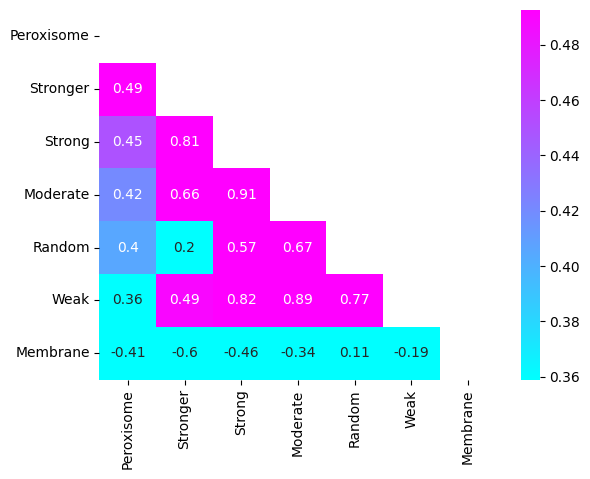

In [58]:
mask = np.zeros_like(df, dtype=bool)
mask[np.triu_indices_from(mask)] = True

plt.close("all")
pex_vals = df_sorted.loc["Peroxisome"].values
min_val = np.min(pex_vals[pex_vals > 0])
max_val = np.max(pex_vals[pex_vals < 0.9])
sns.heatmap(
    df_sorted,
    annot=True,
    cmap="cool",
    vmin=min_val,
    vmax=max_val,
    mask=mask,
)
plt.savefig(
    f"{save_dir}/PILR_correlation_bias_avg_phi.png",
    dpi=300,
    bbox_inches="tight",
)

### Plot different gradients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def normalize_values(values):
    return (values - np.min(values)) / (np.max(values) - np.min(values))

In [ ]:
xvals = np.linspace(0.001,1,1000)
weak_vals = normalize_values(np.exp(-xvals / 0.9)) # (1 - xvals)
mod_vals = normalize_values(np.exp(-xvals / 0.3)) # (1 - xvals) ** 3
str_vals = normalize_values(np.exp(-xvals / 0.1)) # (1 - xvals) ** 8

fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=300)
ax.plot(xvals, weak_vals, label="Weak", linewidth=4, c="C3")
ax.plot(xvals, mod_vals, label="Moderate", linewidth=4, c="C4")
ax.plot(xvals, str_vals, label="Strong", linewidth=4, c="C5")
ax.legend(fontsize=18)
ax.set_yticks([])
ax.set_xticks([0, 1])
ax.set_xticklabels(["nucleus", "cell membrane"], fontsize=18)
ax.set_ylabel("Relative probability", fontsize=18)
plt.show()